# Predicting market direction

In [1]:
import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator

import mlflow

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve, 
    confusion_matrix, 
    recall_score, 
    accuracy_score, 
    precision_score,
    plot_roc_curve,
)

In [2]:
%matplotlib inline

In [3]:
sns.set(style='darkgrid')

## Get Data

Read JSON files

In [4]:
sent_raw = pd.read_pickle('data/sentiment_df.pickle').rename(columns={'publish_date':'date'})
sent_raw.date = pd.to_datetime(sent_raw.date, utc=True).dt.tz_localize(None)

In [5]:
large_cap_raw = pd.read_json('data/large_cap.json', orient='records')
large_cap_raw.date = pd.to_datetime(large_cap_raw.date)
large_cap_raw['pct_change'] = large_cap_raw.close.pct_change().shift(-1)
large_cap_raw['price_increase'] = (large_cap_raw['pct_change']  > 0).astype('uint8')

In [6]:
small_cap_raw = pd.read_json('data/small_cap.json', orient='records')
small_cap_raw.date = pd.to_datetime(small_cap_raw.date)
small_cap_raw['pct_change'] = small_cap_raw.close.pct_change().shift(-1)
small_cap_raw['price_increase'] = (small_cap_raw['pct_change']  > 0).astype('uint8')

In [7]:
gbpeur_raw =  pd.read_json('data/gbp_eur.json', orient='records')
gbpeur_raw.date = pd.to_datetime(gbpeur_raw.date)
gbpeur_raw['pct_change'] = gbpeur_raw.close.pct_change().shift(-1)
gbpeur_raw['price_increase'] = (gbpeur_raw['pct_change'] > 0).astype('uint8')

In [8]:
gbpusd_raw = pd.read_json('data/gbp_usd.json', orient='records')
gbpusd_raw.date = pd.to_datetime(gbpusd_raw.date)
gbpusd_raw['pct_change'] = gbpusd_raw.close.pct_change().shift(-1)
gbpusd_raw['price_increase'] = (gbpusd_raw['pct_change'] > 0).astype('uint8')

Merge the stock price data with sentiment data

In [9]:
# resample to daily interval for fx data
sent_df = sent_raw.set_index('date')['2015-01-01':].resample('D').mean().fillna(method='bfill')

In [10]:
drop_columns = ['open','high', 'low', 'close']

In [11]:
small_cap_df = small_cap_raw.set_index('date')['2015-01-01':'2019-08-30'].join(sent_df).drop(
    columns=drop_columns+['stock', 'volume']
)

In [12]:
large_cap_df = large_cap_raw.set_index('date')['2015-01-01':'2019-08-30'].join(sent_df).drop(
    columns=drop_columns+['stock', 'volume']
)

In [13]:
gbpeur_df = gbpeur_raw.set_index('date')['2015-01-01':'2019-08-30'].join(sent_df).drop(
    columns=drop_columns+['fx_pair']
)

In [14]:
gbpusd_df = gbpusd_raw.set_index('date')['2015-01-01':'2019-08-30'].join(sent_df).drop(
    columns=drop_columns+['fx_pair']
)

## EDA on the Raw Features

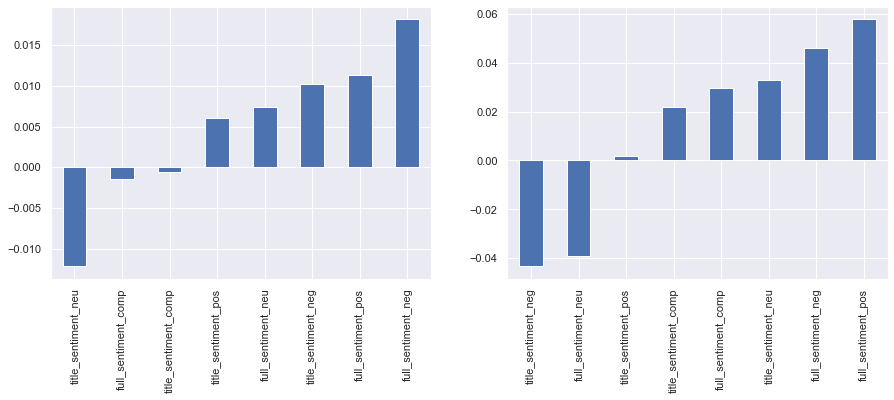

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
large_cap_df.corr()['pct_change'].drop(['pct_change', 'price_increase']).sort_values().plot(kind='bar', ax=ax[0])
large_cap_df.corr()['price_increase'].drop(['pct_change', 'price_increase']).sort_values().plot(kind='bar', ax=ax[1])

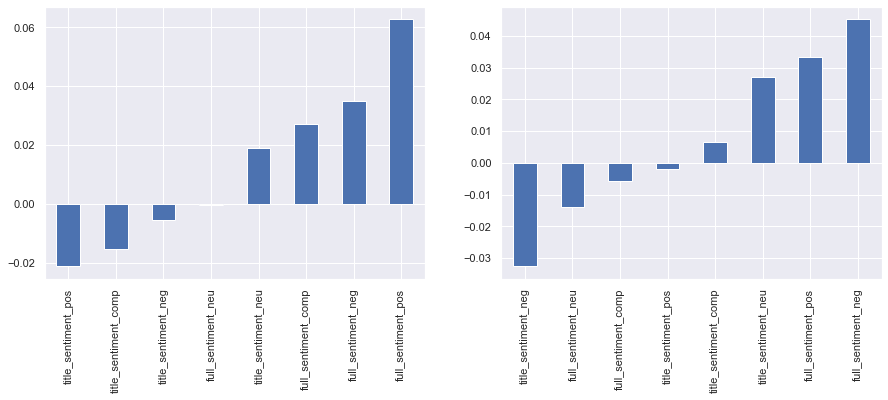

In [16]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
small_cap_df.corr()['pct_change'].drop(['pct_change', 'price_increase']).sort_values().plot(kind='bar', ax=ax[0])
small_cap_df.corr()['price_increase'].drop(['pct_change', 'price_increase']).sort_values().plot(kind='bar', ax=ax[1])

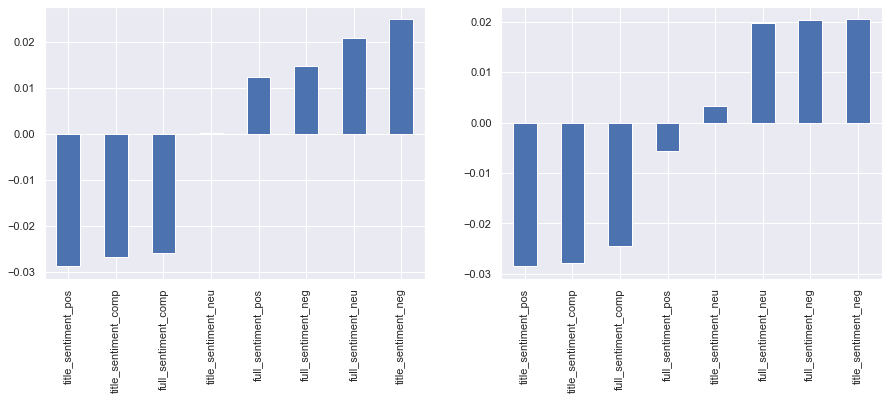

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
gbpeur_df.corr()['pct_change'].drop(['pct_change', 'price_increase']).sort_values().plot(kind='bar', ax=ax[0])
gbpeur_df.corr()['price_increase'].drop(['pct_change', 'price_increase']).sort_values().plot(kind='bar', ax=ax[1])

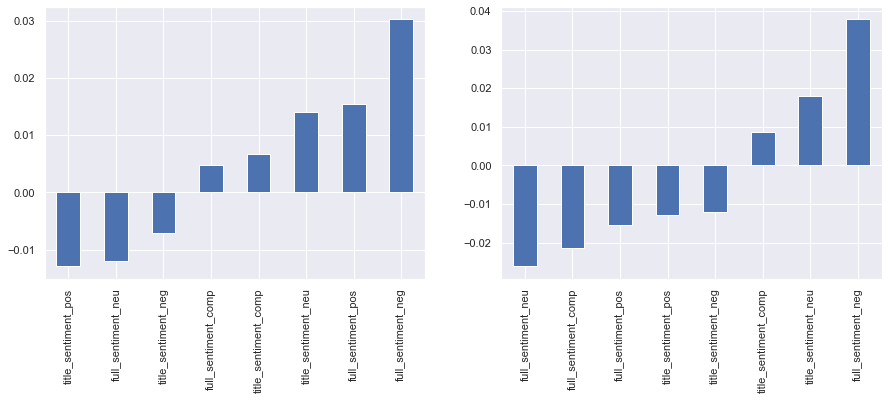

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
gbpusd_df.corr()['pct_change'].drop(['pct_change', 'price_increase']).sort_values().plot(kind='bar', ax=ax[0])
gbpusd_df.corr()['price_increase'].drop(['pct_change', 'price_increase']).sort_values().plot(kind='bar', ax=ax[1])

## Feature Engineering

In [19]:
raw_features = [
    'title_sentiment_pos','title_sentiment_neu', 'title_sentiment_neg', 'title_sentiment_comp',
    'full_sentiment_pos', 'full_sentiment_neu', 'full_sentiment_neg','full_sentiment_comp'
]

In [20]:
datasets = [small_cap_df, large_cap_df, gbpeur_df, gbpusd_df]

Generate expanding window features

In [21]:
for data in datasets:
    for feature in raw_features:
        data[f'{feature}_expanding_sum'] = data[feature].expanding().sum()
        data[f'{feature}_expanding_avg'] = data[feature].expanding().mean()

Generate lag features

In [22]:
for data in datasets:
    for feature in raw_features:
        for lag in [1, 3, 5, 10]:
             data[f'{feature}(T-{lag})'] = data[feature].shift(lag)

Generate rolling windows

In [23]:
for data in datasets:
    for feature in raw_features:
        for window in [3, 5, 10]:
            data[f'{feature}_{window}_m_avg'] = data[feature].rolling(window).mean()
            data[f'{feature}_{window}_sum'] = data[feature].rolling(window).sum()
            data[f'{feature}_{window}_min'] = data[feature].rolling(window).min()
            data[f'{feature}_{window}_max'] = data[feature].rolling(window).max()

Generate date time features

In [24]:
for data in datasets:
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day_of_week'] = data.index.dayofweek

## EDA on New Features

Number of Potential Features

In [25]:
print(datasets[0].shape[1] -2)

155


Deal with missing values. Maximum amount of data that will be removed if we delete all rows with nulls is 1.1%

In [26]:
for data in datasets:
    print(100*data.isna().sum().max()/len(data))

1.1073253833049403
1.1073253833049403
1.08843537414966
1.0738255033557047


In [27]:
for data in datasets:
    data.dropna(inplace=True)

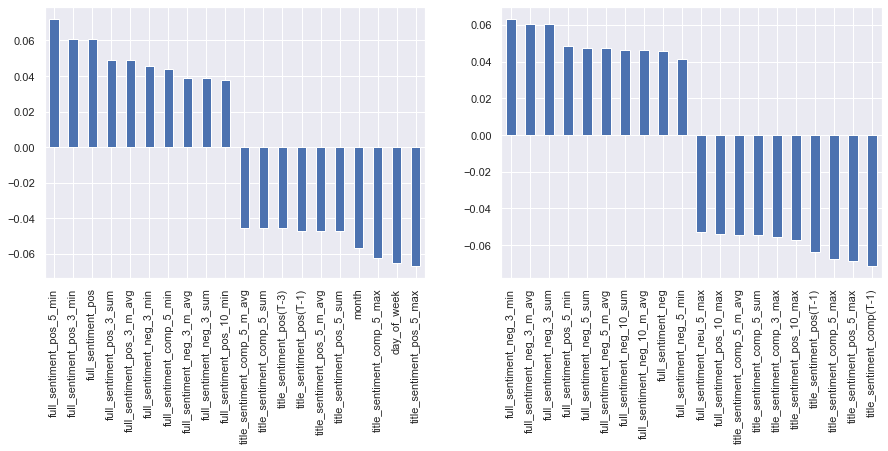

In [28]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
corr = small_cap_df.corr()['pct_change'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)
pd.concat([corr[:10],corr[-10:]]).plot(kind='bar', ax=ax[0])
corr = small_cap_df.corr()['price_increase'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)
pd.concat([corr[:10],corr[-10:]]).plot(kind='bar', ax=ax[1])

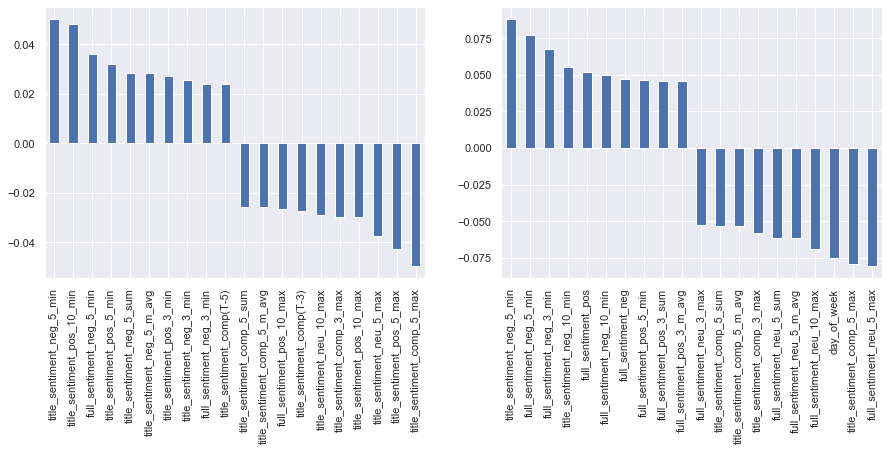

In [29]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
corr = large_cap_df.corr()['pct_change'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)
pd.concat([corr[:10],corr[-10:]]).plot(kind='bar', ax=ax[0])
corr = large_cap_df.corr()['price_increase'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)
pd.concat([corr[:10],corr[-10:]]).plot(kind='bar', ax=ax[1])

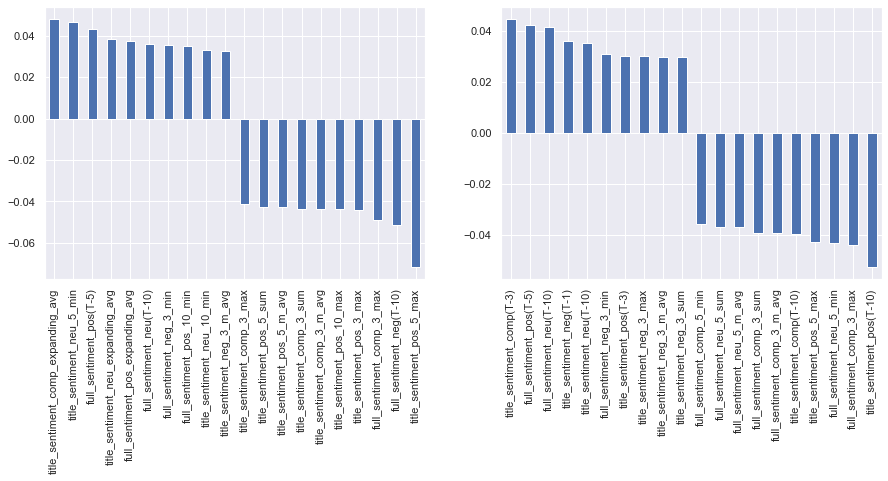

In [30]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
corr = gbpeur_df.corr()['pct_change'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)
pd.concat([corr[:10],corr[-10:]]).plot(kind='bar', ax=ax[0])
corr = gbpeur_df.corr()['price_increase'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)
pd.concat([corr[:10],corr[-10:]]).plot(kind='bar', ax=ax[1])

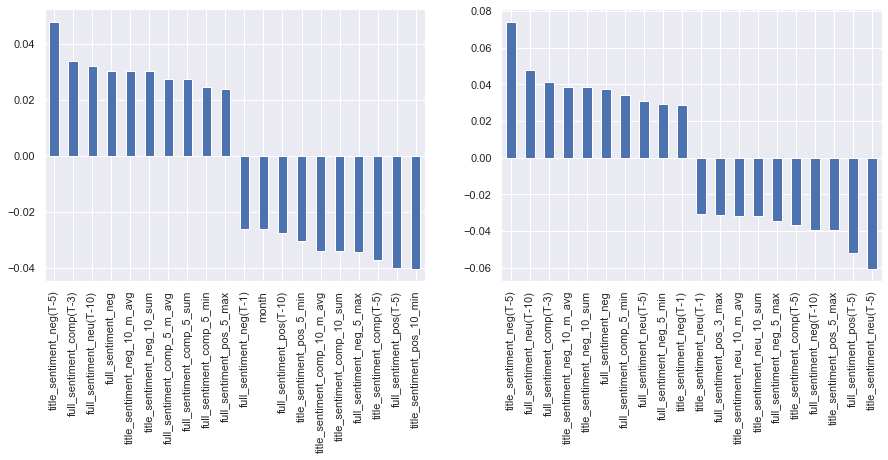

In [31]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
corr = gbpusd_df.corr()['pct_change'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)
pd.concat([corr[:10],corr[-10:]]).plot(kind='bar', ax=ax[0])
corr = gbpusd_df.corr()['price_increase'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)
pd.concat([corr[:10],corr[-10:]]).plot(kind='bar', ax=ax[1])

## Feature Importance

In [32]:
datasets_split = []
for i, data in enumerate(datasets,1):
    train, test = np.split(data, [int(0.8*len(data))])
    datasets_split.append({'train': train, 'test': test})

In [33]:
list_fi = []
for data in datasets_split:
    X_train, y_train = data['train'].drop(['pct_change', 'price_increase'], axis=1), data['train']['price_increase'] 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    rfr = RandomForestClassifier(n_estimators=100)
    rfr.fit(X_train, y_train)
    fi = pd.DataFrame(np.c_[data['train'].drop(['pct_change', 'price_increase'],axis=1).columns, rfr.feature_importances_], columns=['feature', 'importance'])
    list_fi.append(
        {
            'mean' :fi.importance.mean(), 'std' :fi.importance.std(), 'max' : fi.importance.max(), 'min': fi.importance.min()
        }
    )

lag features seem to have the highest feature importance, while the rolling min max and date features seem to be the worse

In [34]:
list_fi

[{'mean': 0.006451612903225806,
  'std': 0.0014420012021616536,
  'max': 0.010901611585484493,
  'min': 0.0004777228669882292},
 {'mean': 0.0064516129032258064,
  'std': 0.001606658189836232,
  'max': 0.010806460777569088,
  'min': 0.0003285984488759368},
 {'mean': 0.006451612903225808,
  'std': 0.0014814612863636018,
  'max': 0.011418211476085446,
  'min': 0.0006696888931383871},
 {'mean': 0.006451612903225805,
  'std': 0.0016834269213282453,
  'max': 0.012785715385247415,
  'min': 0.00024594481113975546}]

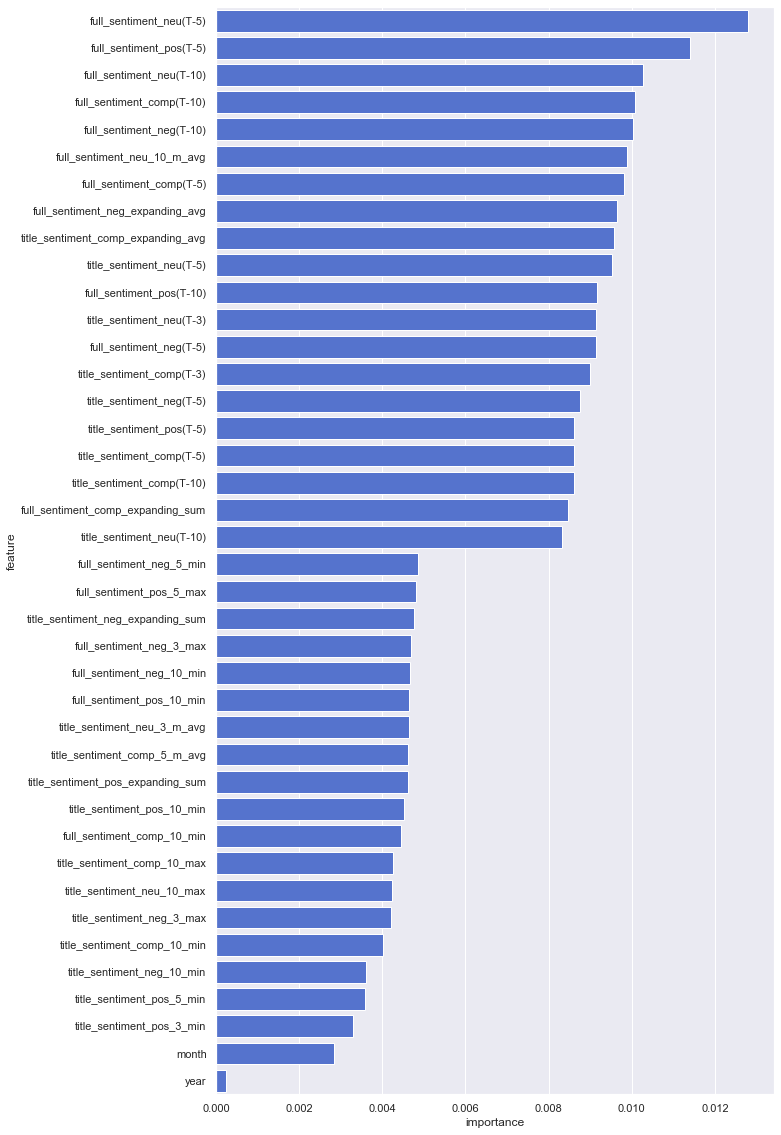

In [35]:
stag = fi.sort_values('importance', ascending=False)
plot = pd.concat([stag.iloc[:20], stag.iloc[-20:]])
plt.figure(figsize=(10,20))
sns.barplot(y='feature', x='importance', data=plot, color='royalblue')

## Base Model

Just by guessing that the price will always increase you get the accuracy below. I will be using this as my base model to provide some context to the performance of the other models built later on

In [36]:
class BaseClassifier(BaseEstimator):
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X, y=None):
        
        return [1]*X.shape[0]

In [37]:
names = ['small_cap', 'large_cap', 'gbpeur', 'gbpusd']

In [38]:
results = []
for name, data in zip(names, datasets_split):
    X_test, y_test = data['test'].drop(['pct_change', 'price_increase'], axis=1), data['test']['price_increase'] 
    clf = BaseClassifier()
    y_pred = clf.predict(X=X_test)
    results.append(
        {
            'model': 'BaseModel',
            'dataset': name,
            'accuracy': accuracy_score(y_test.values, y_pred),
            'recall': recall_score(y_test.values, y_pred),
            'precision': precision_score(y_test.values, y_pred),
            'roc_auc': roc_auc_score(y_test.values, y_pred),
        }

    )
base_results_df = pd.DataFrame(results).melt(id_vars=['model', 'dataset'])

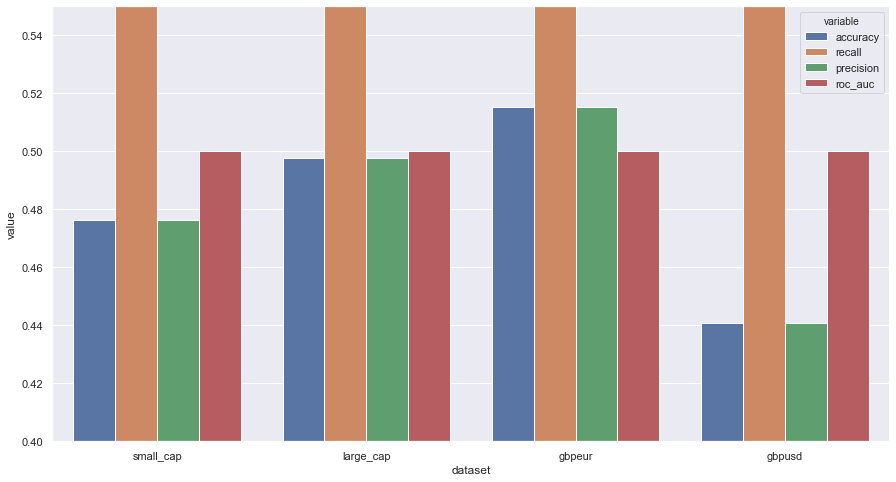

In [39]:
plt.figure(figsize=(15,8))
plt.ylim(0.40, 0.55)
sns.barplot(x='dataset', y='value', data=base_results_df, hue='variable')

Code to log performance on mlflow
```python
names = ['small_cap', 'large_cap', 'gbpeur', 'gbpusd']
for name, data in zip(names, datasets_split):
    with mlflow.start_run(experiment_id=5) as run:
        X_test, y_test = data['test'].drop(['pct_change', 'price_increase'], axis=1), data['test']['price_increase'] 
        clf = BaseClassifier()
        y_pred = clf.predict(X=X_test)
        mlflow.log_param('model', 'BaseModel')
        mlflow.log_param('dataset', name)
        mlflow.log_metric('accuracy', accuracy_score(y_test.values, y_pred))
        mlflow.log_metric('recall', recall_score(y_test.values, y_pred))
        mlflow.log_metric('precision', precision_score(y_test.values, y_pred))
        mlflow.log_metric('roc_auc', roc_auc_score(y_test.values, y_pred))
```

## Train and Evaluate Model

Models I tried out are as follows: Logistic Regression, KNN, Random Forest Classifiers, and SVM. I used kfold cross validation and grid search to tune the hyperparameters. All my runs were logged using mlflow and the results are saved in the results folder. Below are the results from each model trying to predict the target for each of the targets. I tuned the model to run refit for precision weighted as I want to minimise false positives

Example Code to log on mlflow
``` python
for name, data in zip(names,datasets_split):
    with mlflow.start_run(experiment_id=5) as run:
        tss = TimeSeriesSplit(3)
        X_train, y_train = data['train'].drop(['pct_change', 'price_increase'], axis=1), data['train']['price_increase'] 
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        clf = SVC()
        grid = {
            'kernel' : ['poly', 'rbf', 'sigmoid'],
            'C' : [50, 10, 1.0, 0.1, 0.01],
            'gamma': ['auto', 'scale']
        }
        gs = GridSearchCV(
            clf, 
            param_grid=grid, 
            scoring=['roc_auc', 'accuracy', 'recall_weighted', 'precision_weighted'],
            refit='precision_weighted',
            verbose=2,
            cv=tss,
            n_jobs=2
        )
        gs.fit(X_train, y_train)
        mlflow.log_param('model', 'SVC')
        mlflow.log_param('dataset', name)
        mlflow.log_param('refit', 'precision')
        mlflow.log_metric('accuracy', gs.cv_results_['mean_test_accuracy'][gs.best_index_])
        mlflow.log_metric('recall', gs.cv_results_['mean_test_recall_weighted'][gs.best_index_])
        mlflow.log_metric('precision', gs.cv_results_['mean_test_precision_weighted'][gs.best_index_])
        mlflow.log_metric('roc_auc', gs.best_score_)
```

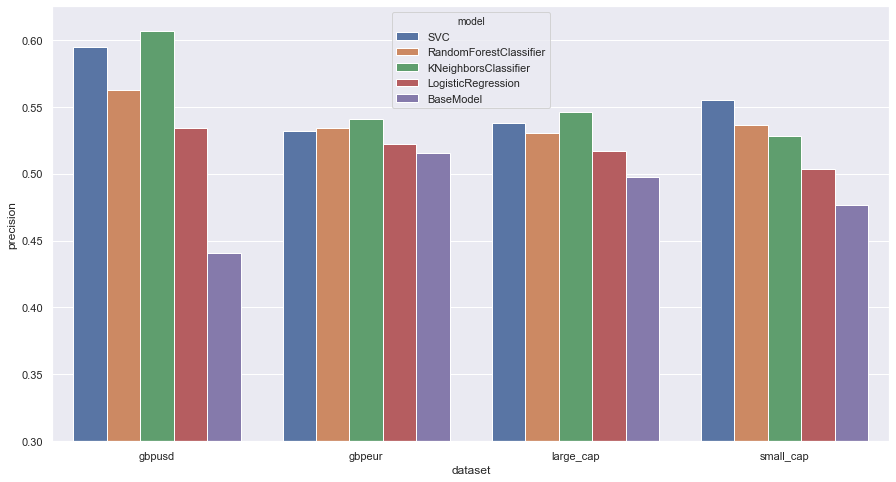

In [40]:
result_df = pd.read_csv('results/second_run.csv')
mask = (result_df.refit=='precision')|(result_df.model=='BaseModel')

plt.figure(figsize=(15,8))
plt.ylim(0.3, 0.625)
sns.barplot(x='dataset', y='precision', data=result_df[mask], hue='model')

The results above show that best model we has was trying to predict whether GBP/USD will increase in price using KNN with parameters below

In [41]:
tss = TimeSeriesSplit(3)
data = datasets_split[3]
X_train, y_train = data['train'].drop(['pct_change', 'price_increase'], axis=1), data['train']['price_increase'] 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
clf = KNeighborsClassifier(algorithm='auto', metric='minkowski')
grid = [ 
    {
        'n_neighbors': range(5, 21, 2),
        'weights' : ['uniform', 'distance'],
        'p': [1, 2]
    },
]
gs = GridSearchCV(
    clf, 
    param_grid=grid, 
    scoring=['roc_auc', 'accuracy', 'recall_weighted', 'precision_weighted'],
    refit='precision_weighted',
    verbose=2,
    cv=tss,
    n_jobs=2
)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.9s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   11.3s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=2,
             param_grid=[{'n_neighbors': range(5, 21, 2), 'p': [1, 2],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit='precision_weighted',
             return_train_score=False,
             scoring=['roc_auc', 'accuracy', 'recall_weighted',
                      'precision_weighted'],
             verbose=2)

In [42]:
gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='distance')

## Test Model

In [43]:
X_test, y_test = data['test'].drop(['pct_change', 'price_increase'], axis=1), data['test']['price_increase'] 
X_test = scaler.transform(X_test)

In [44]:
y_pred = gs.predict(X_test)

### Classification Report

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.36      0.44       165
           1       0.44      0.64      0.52       130

    accuracy                           0.48       295
   macro avg       0.50      0.50      0.48       295
weighted avg       0.50      0.48      0.47       295



### Confusions Matrix

In [46]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(59, 106, 47, 83)

### ROC

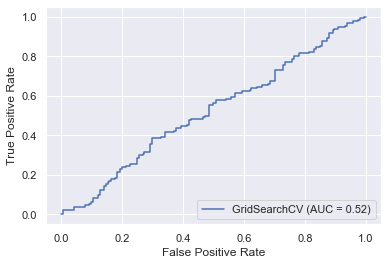

In [47]:
plot_roc_curve(gs,X_test,y_test)

## Conclusion

The table below summaries the results and shows that the Model perfomace is pretty much the same as the base model, which always predicts 1, and hence not much value added. Issue is that the Model predicts too many false positives

| Model         | Metric    | Value |
|---------------|-----------|-------|
| BaseModel     | Precision | 0.44  |
| KNNClassifier | Precision | 0.44  |
| BaseModel     | ROC AUC   | 0.5   |
| KNNClassifier | ROC AUC   | 0.52  |


## Appendix
### Parameter Tuning

Logistic Regression
``` python
clf = LogisticRegression(multi_class='ovr', max_iter=10000000)
grid = [ 
    {
        'C': np.power(10.0,np.arange(-4,3)),
        'penalty': ['l1','l2'],
        'solver': ['liblinear']
    },
    {
        'C': np.power(10.0,np.arange(-4,4)),
        'solver': ['newton-cg', 'lbfgs']
    }
]
```
KNN Classifier
``` python 
clf = KNeighborsClassifier(algorithm='auto', metric='minkowski')
grid = [ 
    {
        'n_neighbors': range(5, 21, 2),
        'weights' : ['uniform', 'distance'],
        'p': [1, 2]
    },
]
```
RFC
``` python
clf = RandomForestClassifier()
grid = [ 
    {
        'n_estimators': np.power(10, range(2,4)),
        'bootstrap': [True, False],
        'max_features'['sqrt', 'log2']
    },
]
```
SVC

``` python
clf = SVC()
grid = {
    'kernel' : ['poly', 'rbf', 'sigmoid'],
    'C' : [50, 10, 1.0, 0.1, 0.01],
    'gamma': ['auto', 'scale']
}
```